# Train classifier heads

- This notebook runs multiple experiments with Linear and MLP classification heads, and different modality combinations
- Saves both the best head model and the logs for each combo

In [1]:
import pandas as pd
import geopandas as gpd

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, random_split
from torchvision import transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import f1_score
import numpy as np

## For consistent shuffling between experiments

In [2]:
seed = 42
torch.manual_seed(seed)
g = torch.Generator().manual_seed(seed)

## Set up a location embedder

- We use rescaled lat/lon values which are centroids of ONS 1km grid
- We need to define it before torch data loader so we can add locs to our datasets

In [3]:
metadata_cols = ['gridimage_id', 'title', 'grid_reference']
metadata = pd.concat([
    pd.read_csv('kaggle_data/metadata.csv', on_bad_lines='skip', usecols=metadata_cols),
    pd.read_csv('kaggle_data/metadata-extra.csv', on_bad_lines='skip', encoding='latin1', usecols=metadata_cols)
])

In [28]:
grid2coords = (
    gpd.read_file(
        'misc/os_bng_grids.gpkg',
        layer='1km_grid'
    ).rename(
        columns={'tile_name': 'grid_reference'}
    )
    .to_crs(4326)
    .assign(
        geom_=lambda gdf_: gdf_.geometry.centroid,
        lat=lambda gdf_: gdf_.geom_.y,
        lon=lambda gdf_: gdf_.geom_.x
    )
    .set_index('grid_reference')
    [['lat', 'lon']].to_dict(orient='index')
)

img2grid = metadata.set_index('gridimage_id').grid_reference.to_dict()


# UK bounds to rescale
uk = {
    'lat': {'min': 49.9, 'max': 61.9},
    'lon': {'min': -8.6, 'max': 2.1}
}

def get_loc_emb(img_id):
    """Get rescaled lat/lon values"""
    try:
        coords_dict = grid2coords[img2grid[img_id]]
        lat, lon = coords_dict['lat'], coords_dict['lon']

        lat_norm = (lat - uk['lat']['min']) / (uk['lat']['max'] - uk['lat']['min'])
        lon_norm = (lon - uk['lon']['min']) / (uk['lon']['max'] - uk['lon']['min'])
    
        return torch.tensor([lat_norm, lon_norm], dtype=torch.float32)
    except:
        return torch.tensor([0, 0], dtype=torch.float32)

def add_location(batch):
    # img_id, img_f, txt_f, loc_f, y
    # batch is a list of items from full_ds[idx], e.g.
    #   [(img_id0, img_f0, txt_f0, label0), (img_id1, img_f1, txt_f1, label1), …]
    
    img_ids, img_fs, txt_fs, loc_fs, labels = [], [], [], [], []
    
    for img_id, img_f, txt_f, label in batch:
        img_ids.append(img_id)
        img_fs.append(img_f)
        txt_fs.append(txt_f)
        loc_fs.append(get_loc_emb(img_id))
        labels.append(label)

    return (
        torch.stack(img_ids),
        torch.stack(img_fs),
        torch.stack(txt_fs),
        torch.stack(loc_fs),
        torch.stack(labels)
    )

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_30100/3917409025.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geom_=lambda gdf_: gdf_.geometry.centroid,


## Load datasets

In [5]:
ds = torch.load('splits/dataset.pt', weights_only=False)
train_idx = torch.load('splits/train_idx.pt', weights_only=False)
val_idx = torch.load('splits/val_idx.pt', weights_only=False)

In [6]:
train_dl = DataLoader(
    Subset(ds, train_idx),
    batch_size=4096, shuffle=True,  num_workers=0, generator=g, # consistent shuffling
    collate_fn=add_location # Add location embeddings
)

val_dl = DataLoader(
    Subset(ds, val_idx),
    batch_size=4096, shuffle=False, num_workers=0,
    collate_fn=add_location
)

In [7]:
print("Samples in training:", len(train_idx))
print("Samples in validation:", len(val_idx))

Samples in training: 517679
Samples in validation: 129420


### Define MixUp helper function

In [8]:
def mixup(features, labels, alpha=0.4):
    """Return mixed features and mixed labels."""
    batch_size = features.size(0)
    # sample mixing coefficient
    lam = torch.distributions.Beta(alpha, alpha).sample((batch_size,)).to(features.device)
    lam = torch.max(lam, 1-lam)           # ensure lam >= 0.5
    lam = lam.view(batch_size, 1)         # shape [B,1]
    
    # shuffle batch
    idx = torch.randperm(batch_size)
    f2, y2 = features[idx], labels[idx]
    
    # mix
    mixed_f = lam * features + (1-lam) * f2
    mixed_y = lam * labels   + (1-lam) * y2   # soft labels
    
    return mixed_f, mixed_y

## Define our main experiment function

In [9]:
def run_experiment(head, use_img, use_txt, use_loc, use_mixup):
    """
    Runs a single experiment and saves best head/training log.
    `head` is 'mlp' or 'linear'.
    `use_img`, `use_txt`, `use_loc`, `use_mixup` are all booleans.
    Two files will be generated: the best head in ./heads, and training logs in ./logs.
    """
    
    experiment_name = f'{head}{"-img" if use_img else ""}{"-txt" if use_txt else ""}{"-loc" if use_loc else ""}{"-mixup" if use_mixup else ""}'
    num_labels = 49
    device = 'cpu'
    best_val = 0.0
    best_f1 = 0.0
    best_epoch = -1
    patience = 10 # Stop if no improvement for 10 epochs
    patience_counter = 0
    epochs = 200
    log_lines = []
    loss_fn = nn.BCEWithLogitsLoss()

    # Calculate classifier input dimension
    input_dim = sum([
        512 if use_img else 0,
        512 if use_txt else 0,
        2 if use_loc else 0
    ])

    # Set up classifier head
    if head == 'mlp':
        head = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_labels)
        ).to(device)
        opt = AdamW(head.parameters(), lr=3e-3, weight_decay=1e-4)
    elif head == 'linear':
        head = nn.Linear(input_dim, num_labels).to(device)
        opt = AdamW(head.parameters(), lr=5e-3, weight_decay=1e-5)
    else:
        print("Classification head must be `mlp` or `linear`!")
        return
    
    sch = CosineAnnealingLR(opt, T_max=epochs//4) # Learning schedule
    
    for epoch in range(epochs):
        head.train()
        tot = 0
        
        for img_id, img_f, txt_f, loc_f, y in train_dl:
            opt.zero_grad()
    
            # Combine modalities into a single embedding
            fused_parts = []
            if use_img:
                fused_parts.append(img_f)
            if use_txt:
                fused_parts.append(txt_f)
            if use_loc:
                fused_parts.append(loc_f)
                
            fused = torch.cat(fused_parts, dim=1)

            if use_mixup:
                mixed_f, mixed_y = mixup(fused, y, alpha=0.2)
                logits = head(mixed_f)
                loss = loss_fn(logits, mixed_y)
            else:
                logits = head(fused)
                loss = loss_fn(logits, y.float())
            
            loss.backward()
            opt.step()
            tot += loss.item() * fused.size(0)
            
        sch.step()
    
        # val‐subset accuracy
        head.eval()
        correct, total = 0, 0
        all_preds, all_targets = [], [] # for per-class F-score
        with torch.no_grad():
            for img_id, img_f, txt_f, loc_f, y in val_dl:
                
                # Combine modalities into a single embedding
                fused_parts = []
                if use_img:
                    fused_parts.append(img_f)
                if use_txt:
                    fused_parts.append(txt_f)
                if use_loc:
                    fused_parts.append(loc_f)
                    
                fused = torch.cat(fused_parts, dim=1)
                
                probs = torch.sigmoid(head(fused))
                preds = (probs > 0.5)
                
                # Store for F1 calculation
                all_preds.append(preds.cpu().numpy())
                all_targets.append(y.cpu().numpy())

                # Subset accuracy: all 49 match?
                correct += (preds.eq(y.bool()).all(dim=1).sum().item())
                total   += fused.size(0)
    
        # Calculate average (macro) F1 score
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        macro_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        
        train_loss = tot/len(train_idx)
        val_acc = correct/total

        log_line = f"Epoch {epoch:02d} \t train_loss {train_loss:.4f} \t val_acc {val_acc:.4f} \t macro_f1 {macro_f1:.4f}"
        log_lines.append(log_line)
        print(log_line)
    
        if val_acc > best_val:
            best_val = val_acc
            best_f1 = macro_f1
            best_epoch = epoch
            patience_counter = 0
            # Save best head
            torch.save(head.state_dict(), f'heads/{experiment_name}.pth')
        else:
            patience_counter += 1
    
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break
    
    log_line = f"======\nBest epoch {best_epoch:02d} \t val_acc {best_val:.4f} \t macro_f1 {best_f1:.4f}"
    log_lines.append(log_line)
    print(log_line)

    # Save logs
    with open(f'logs/{experiment_name}.txt', 'w') as f:
        f.write('\n'.join(log_lines))

## Run all combinations
### Image embeddings only

In [67]:
%%time
run_experiment('linear', use_img=True, use_txt=False, use_loc=False, use_mixup=False)

Epoch 00 	 train_loss 0.1284 	 val_acc 0.1729 	 macro_f1 0.3038
Epoch 01 	 train_loss 0.0953 	 val_acc 0.1949 	 macro_f1 0.3578
Epoch 02 	 train_loss 0.0926 	 val_acc 0.2031 	 macro_f1 0.3754
Epoch 03 	 train_loss 0.0914 	 val_acc 0.2071 	 macro_f1 0.3835
Epoch 04 	 train_loss 0.0907 	 val_acc 0.2090 	 macro_f1 0.3887
Epoch 05 	 train_loss 0.0902 	 val_acc 0.2110 	 macro_f1 0.3938
Epoch 06 	 train_loss 0.0898 	 val_acc 0.2128 	 macro_f1 0.3942
Epoch 07 	 train_loss 0.0895 	 val_acc 0.2134 	 macro_f1 0.3955
Epoch 08 	 train_loss 0.0893 	 val_acc 0.2156 	 macro_f1 0.4001
Epoch 09 	 train_loss 0.0891 	 val_acc 0.2158 	 macro_f1 0.3985
Epoch 10 	 train_loss 0.0889 	 val_acc 0.2172 	 macro_f1 0.4028
Epoch 11 	 train_loss 0.0888 	 val_acc 0.2189 	 macro_f1 0.4040
Epoch 12 	 train_loss 0.0887 	 val_acc 0.2190 	 macro_f1 0.4034
Epoch 13 	 train_loss 0.0885 	 val_acc 0.2186 	 macro_f1 0.4059
Epoch 14 	 train_loss 0.0885 	 val_acc 0.2191 	 macro_f1 0.4055
Epoch 15 	 train_loss 0.0884 	 val_acc 0

In [68]:
%%time
run_experiment('linear', use_img=True, use_txt=False, use_loc=False, use_mixup=True)

Epoch 00 	 train_loss 0.1355 	 val_acc 0.1754 	 macro_f1 0.3151
Epoch 01 	 train_loss 0.1045 	 val_acc 0.1985 	 macro_f1 0.3738
Epoch 02 	 train_loss 0.1022 	 val_acc 0.2074 	 macro_f1 0.3916
Epoch 03 	 train_loss 0.1012 	 val_acc 0.2118 	 macro_f1 0.4041
Epoch 04 	 train_loss 0.1005 	 val_acc 0.2159 	 macro_f1 0.4088
Epoch 05 	 train_loss 0.1002 	 val_acc 0.2162 	 macro_f1 0.4095
Epoch 06 	 train_loss 0.0998 	 val_acc 0.2184 	 macro_f1 0.4156
Epoch 07 	 train_loss 0.0996 	 val_acc 0.2192 	 macro_f1 0.4163
Epoch 08 	 train_loss 0.0994 	 val_acc 0.2200 	 macro_f1 0.4201
Epoch 09 	 train_loss 0.0992 	 val_acc 0.2205 	 macro_f1 0.4184
Epoch 10 	 train_loss 0.0991 	 val_acc 0.2213 	 macro_f1 0.4230
Epoch 11 	 train_loss 0.0990 	 val_acc 0.2218 	 macro_f1 0.4197
Epoch 12 	 train_loss 0.0989 	 val_acc 0.2220 	 macro_f1 0.4225
Epoch 13 	 train_loss 0.0989 	 val_acc 0.2225 	 macro_f1 0.4271
Epoch 14 	 train_loss 0.0988 	 val_acc 0.2240 	 macro_f1 0.4262
Epoch 15 	 train_loss 0.0987 	 val_acc 0

In [69]:
%%time
run_experiment('mlp', use_img=True, use_txt=False, use_loc=False, use_mixup=False)

Epoch 00 	 train_loss 0.1413 	 val_acc 0.1488 	 macro_f1 0.2310
Epoch 01 	 train_loss 0.1010 	 val_acc 0.1804 	 macro_f1 0.2877
Epoch 02 	 train_loss 0.0978 	 val_acc 0.1878 	 macro_f1 0.3103
Epoch 03 	 train_loss 0.0964 	 val_acc 0.1933 	 macro_f1 0.3210
Epoch 04 	 train_loss 0.0954 	 val_acc 0.1987 	 macro_f1 0.3356
Epoch 05 	 train_loss 0.0947 	 val_acc 0.1995 	 macro_f1 0.3381
Epoch 06 	 train_loss 0.0942 	 val_acc 0.2026 	 macro_f1 0.3420
Epoch 07 	 train_loss 0.0938 	 val_acc 0.2030 	 macro_f1 0.3474
Epoch 08 	 train_loss 0.0935 	 val_acc 0.2040 	 macro_f1 0.3479
Epoch 09 	 train_loss 0.0932 	 val_acc 0.2052 	 macro_f1 0.3487
Epoch 10 	 train_loss 0.0929 	 val_acc 0.2083 	 macro_f1 0.3579
Epoch 11 	 train_loss 0.0927 	 val_acc 0.2071 	 macro_f1 0.3538
Epoch 12 	 train_loss 0.0924 	 val_acc 0.2102 	 macro_f1 0.3592
Epoch 13 	 train_loss 0.0923 	 val_acc 0.2084 	 macro_f1 0.3560
Epoch 14 	 train_loss 0.0921 	 val_acc 0.2112 	 macro_f1 0.3644
Epoch 15 	 train_loss 0.0920 	 val_acc 0

In [70]:
%%time
run_experiment('mlp', use_img=True, use_txt=False, use_loc=False, use_mixup=True)

Epoch 00 	 train_loss 0.1507 	 val_acc 0.1324 	 macro_f1 0.1991
Epoch 01 	 train_loss 0.1112 	 val_acc 0.1659 	 macro_f1 0.2601
Epoch 02 	 train_loss 0.1079 	 val_acc 0.1771 	 macro_f1 0.2861
Epoch 03 	 train_loss 0.1065 	 val_acc 0.1837 	 macro_f1 0.3002
Epoch 04 	 train_loss 0.1058 	 val_acc 0.1871 	 macro_f1 0.3115
Epoch 05 	 train_loss 0.1051 	 val_acc 0.1903 	 macro_f1 0.3140
Epoch 06 	 train_loss 0.1048 	 val_acc 0.1917 	 macro_f1 0.3211
Epoch 07 	 train_loss 0.1044 	 val_acc 0.1916 	 macro_f1 0.3234
Epoch 08 	 train_loss 0.1041 	 val_acc 0.1935 	 macro_f1 0.3240
Epoch 09 	 train_loss 0.1037 	 val_acc 0.1968 	 macro_f1 0.3321
Epoch 10 	 train_loss 0.1035 	 val_acc 0.1965 	 macro_f1 0.3327
Epoch 11 	 train_loss 0.1033 	 val_acc 0.1990 	 macro_f1 0.3364
Epoch 12 	 train_loss 0.1030 	 val_acc 0.2002 	 macro_f1 0.3401
Epoch 13 	 train_loss 0.1028 	 val_acc 0.2007 	 macro_f1 0.3418
Epoch 14 	 train_loss 0.1026 	 val_acc 0.2011 	 macro_f1 0.3414
Epoch 15 	 train_loss 0.1025 	 val_acc 0

### Title embeddings only

In [71]:
%%time
run_experiment('linear', use_img=False, use_txt=True, use_loc=False, use_mixup=False)

Epoch 00 	 train_loss 0.1366 	 val_acc 0.2049 	 macro_f1 0.3687
Epoch 01 	 train_loss 0.0946 	 val_acc 0.2398 	 macro_f1 0.4409
Epoch 02 	 train_loss 0.0912 	 val_acc 0.2505 	 macro_f1 0.4634
Epoch 03 	 train_loss 0.0896 	 val_acc 0.2570 	 macro_f1 0.4723
Epoch 04 	 train_loss 0.0887 	 val_acc 0.2613 	 macro_f1 0.4793
Epoch 05 	 train_loss 0.0881 	 val_acc 0.2641 	 macro_f1 0.4848
Epoch 06 	 train_loss 0.0877 	 val_acc 0.2658 	 macro_f1 0.4871
Epoch 07 	 train_loss 0.0873 	 val_acc 0.2676 	 macro_f1 0.4918
Epoch 08 	 train_loss 0.0871 	 val_acc 0.2684 	 macro_f1 0.4920
Epoch 09 	 train_loss 0.0868 	 val_acc 0.2689 	 macro_f1 0.4925
Epoch 10 	 train_loss 0.0867 	 val_acc 0.2702 	 macro_f1 0.4945
Epoch 11 	 train_loss 0.0865 	 val_acc 0.2711 	 macro_f1 0.4956
Epoch 12 	 train_loss 0.0864 	 val_acc 0.2708 	 macro_f1 0.4952
Epoch 13 	 train_loss 0.0863 	 val_acc 0.2715 	 macro_f1 0.4983
Epoch 14 	 train_loss 0.0862 	 val_acc 0.2721 	 macro_f1 0.4987
Epoch 15 	 train_loss 0.0861 	 val_acc 0

In [72]:
%%time
run_experiment('linear', use_img=False, use_txt=True, use_loc=False, use_mixup=True)

Epoch 00 	 train_loss 0.1446 	 val_acc 0.2055 	 macro_f1 0.3741
Epoch 01 	 train_loss 0.1039 	 val_acc 0.2429 	 macro_f1 0.4524
Epoch 02 	 train_loss 0.1008 	 val_acc 0.2541 	 macro_f1 0.4748
Epoch 03 	 train_loss 0.0995 	 val_acc 0.2593 	 macro_f1 0.4846
Epoch 04 	 train_loss 0.0986 	 val_acc 0.2637 	 macro_f1 0.4934
Epoch 05 	 train_loss 0.0981 	 val_acc 0.2671 	 macro_f1 0.4968
Epoch 06 	 train_loss 0.0977 	 val_acc 0.2681 	 macro_f1 0.4986
Epoch 07 	 train_loss 0.0975 	 val_acc 0.2702 	 macro_f1 0.5037
Epoch 08 	 train_loss 0.0972 	 val_acc 0.2710 	 macro_f1 0.5040
Epoch 09 	 train_loss 0.0971 	 val_acc 0.2720 	 macro_f1 0.5059
Epoch 10 	 train_loss 0.0969 	 val_acc 0.2736 	 macro_f1 0.5078
Epoch 11 	 train_loss 0.0967 	 val_acc 0.2743 	 macro_f1 0.5105
Epoch 12 	 train_loss 0.0967 	 val_acc 0.2746 	 macro_f1 0.5103
Epoch 13 	 train_loss 0.0966 	 val_acc 0.2748 	 macro_f1 0.5119
Epoch 14 	 train_loss 0.0964 	 val_acc 0.2752 	 macro_f1 0.5109
Epoch 15 	 train_loss 0.0963 	 val_acc 0

In [73]:
%%time
run_experiment('mlp', use_img=False, use_txt=True, use_loc=False, use_mixup=False)

Epoch 00 	 train_loss 0.1452 	 val_acc 0.1931 	 macro_f1 0.3229
Epoch 01 	 train_loss 0.0981 	 val_acc 0.2304 	 macro_f1 0.3992
Epoch 02 	 train_loss 0.0946 	 val_acc 0.2458 	 macro_f1 0.4296
Epoch 03 	 train_loss 0.0928 	 val_acc 0.2539 	 macro_f1 0.4424
Epoch 04 	 train_loss 0.0917 	 val_acc 0.2597 	 macro_f1 0.4525
Epoch 05 	 train_loss 0.0910 	 val_acc 0.2626 	 macro_f1 0.4547
Epoch 06 	 train_loss 0.0904 	 val_acc 0.2662 	 macro_f1 0.4644
Epoch 07 	 train_loss 0.0899 	 val_acc 0.2676 	 macro_f1 0.4668
Epoch 08 	 train_loss 0.0894 	 val_acc 0.2702 	 macro_f1 0.4704
Epoch 09 	 train_loss 0.0891 	 val_acc 0.2742 	 macro_f1 0.4763
Epoch 10 	 train_loss 0.0888 	 val_acc 0.2749 	 macro_f1 0.4765
Epoch 11 	 train_loss 0.0885 	 val_acc 0.2763 	 macro_f1 0.4791
Epoch 12 	 train_loss 0.0883 	 val_acc 0.2773 	 macro_f1 0.4811
Epoch 13 	 train_loss 0.0881 	 val_acc 0.2793 	 macro_f1 0.4843
Epoch 14 	 train_loss 0.0879 	 val_acc 0.2781 	 macro_f1 0.4828
Epoch 15 	 train_loss 0.0877 	 val_acc 0

In [74]:
%%time
run_experiment('mlp', use_img=False, use_txt=True, use_loc=False, use_mixup=True)

Epoch 00 	 train_loss 0.1547 	 val_acc 0.1756 	 macro_f1 0.2882
Epoch 01 	 train_loss 0.1084 	 val_acc 0.2176 	 macro_f1 0.3726
Epoch 02 	 train_loss 0.1050 	 val_acc 0.2298 	 macro_f1 0.4000
Epoch 03 	 train_loss 0.1034 	 val_acc 0.2399 	 macro_f1 0.4176
Epoch 04 	 train_loss 0.1025 	 val_acc 0.2457 	 macro_f1 0.4275
Epoch 05 	 train_loss 0.1018 	 val_acc 0.2509 	 macro_f1 0.4385
Epoch 06 	 train_loss 0.1012 	 val_acc 0.2541 	 macro_f1 0.4427
Epoch 07 	 train_loss 0.1008 	 val_acc 0.2556 	 macro_f1 0.4461
Epoch 08 	 train_loss 0.1004 	 val_acc 0.2601 	 macro_f1 0.4518
Epoch 09 	 train_loss 0.1001 	 val_acc 0.2587 	 macro_f1 0.4553
Epoch 10 	 train_loss 0.0998 	 val_acc 0.2649 	 macro_f1 0.4615
Epoch 11 	 train_loss 0.0996 	 val_acc 0.2625 	 macro_f1 0.4584
Epoch 12 	 train_loss 0.0994 	 val_acc 0.2635 	 macro_f1 0.4579
Epoch 13 	 train_loss 0.0991 	 val_acc 0.2656 	 macro_f1 0.4623
Epoch 14 	 train_loss 0.0990 	 val_acc 0.2677 	 macro_f1 0.4674
Epoch 15 	 train_loss 0.0988 	 val_acc 0

## Location only
* Here, validation accuracy never exceeds 0.0 so we don't even save the best model/head

In [75]:
%%time
run_experiment('linear', use_img=False, use_txt=False, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.5959 	 val_acc 0.0000 	 macro_f1 0.0071
Epoch 01 	 train_loss 0.4147 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 02 	 train_loss 0.3121 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 03 	 train_loss 0.2536 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 04 	 train_loss 0.2192 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 05 	 train_loss 0.1982 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 06 	 train_loss 0.1849 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 07 	 train_loss 0.1762 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 08 	 train_loss 0.1703 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 09 	 train_loss 0.1663 	 val_acc 0.0000 	 macro_f1 0.0000
Early stopping at epoch 9 (no improvement for 10 epochs)
Best epoch 09 	 val_acc 0.0000 	 macro_f1 0.0000
CPU times: user 1min 52s, sys: 5min 38s, total: 7min 30s
Wall time: 1min 9s


In [76]:
%%time
run_experiment('linear', use_img=False, use_txt=False, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.5563 	 val_acc 0.0242 	 macro_f1 0.0028
Epoch 01 	 train_loss 0.3878 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 02 	 train_loss 0.2941 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 03 	 train_loss 0.2413 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 04 	 train_loss 0.2105 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 05 	 train_loss 0.1919 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 06 	 train_loss 0.1802 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 07 	 train_loss 0.1726 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 08 	 train_loss 0.1676 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 09 	 train_loss 0.1642 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 10 	 train_loss 0.1618 	 val_acc 0.0000 	 macro_f1 0.0000
Early stopping at epoch 10 (no improvement for 10 epochs)
Best epoch 10 	 val_acc 0.0242 	 macro_f1 0.0028
CPU times: user 2min 1s, sys: 6min 5s, total: 8min 6s
Wall time: 1min 15s


In [77]:
%%time
run_experiment('mlp', use_img=False, use_txt=False, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.1870 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 01 	 train_loss 0.1579 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 02 	 train_loss 0.1577 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 03 	 train_loss 0.1576 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 04 	 train_loss 0.1574 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 05 	 train_loss 0.1573 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 06 	 train_loss 0.1573 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 07 	 train_loss 0.1572 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 08 	 train_loss 0.1572 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 09 	 train_loss 0.1572 	 val_acc 0.0000 	 macro_f1 0.0000
Early stopping at epoch 9 (no improvement for 10 epochs)
Best epoch 09 	 val_acc 0.0000 	 macro_f1 0.0000
CPU times: user 2min 7s, sys: 6min 28s, total: 8min 36s
Wall time: 1min 19s


In [78]:
%%time
run_experiment('mlp', use_img=False, use_txt=False, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.1902 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 01 	 train_loss 0.1580 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 02 	 train_loss 0.1578 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 03 	 train_loss 0.1576 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 04 	 train_loss 0.1575 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 05 	 train_loss 0.1574 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 06 	 train_loss 0.1573 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 07 	 train_loss 0.1573 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 08 	 train_loss 0.1573 	 val_acc 0.0000 	 macro_f1 0.0000
Epoch 09 	 train_loss 0.1572 	 val_acc 0.0000 	 macro_f1 0.0000
Early stopping at epoch 9 (no improvement for 10 epochs)
Best epoch 09 	 val_acc 0.0000 	 macro_f1 0.0000
CPU times: user 2min 5s, sys: 6min 24s, total: 8min 30s
Wall time: 1min 18s


### Image + title embeddings

In [79]:
%%time
run_experiment('linear', use_img=True, use_txt=True, use_loc=False, use_mixup=True)

Epoch 00 	 train_loss 0.1192 	 val_acc 0.2681 	 macro_f1 0.4974
Epoch 01 	 train_loss 0.0897 	 val_acc 0.2941 	 macro_f1 0.5418
Epoch 02 	 train_loss 0.0873 	 val_acc 0.3036 	 macro_f1 0.5589
Epoch 03 	 train_loss 0.0864 	 val_acc 0.3086 	 macro_f1 0.5680
Epoch 04 	 train_loss 0.0858 	 val_acc 0.3127 	 macro_f1 0.5745
Epoch 05 	 train_loss 0.0852 	 val_acc 0.3147 	 macro_f1 0.5788
Epoch 06 	 train_loss 0.0849 	 val_acc 0.3164 	 macro_f1 0.5808
Epoch 07 	 train_loss 0.0847 	 val_acc 0.3191 	 macro_f1 0.5824
Epoch 08 	 train_loss 0.0845 	 val_acc 0.3201 	 macro_f1 0.5855
Epoch 09 	 train_loss 0.0843 	 val_acc 0.3210 	 macro_f1 0.5859
Epoch 10 	 train_loss 0.0842 	 val_acc 0.3218 	 macro_f1 0.5872
Epoch 11 	 train_loss 0.0841 	 val_acc 0.3223 	 macro_f1 0.5874
Epoch 12 	 train_loss 0.0840 	 val_acc 0.3235 	 macro_f1 0.5923
Epoch 13 	 train_loss 0.0839 	 val_acc 0.3242 	 macro_f1 0.5889
Epoch 14 	 train_loss 0.0839 	 val_acc 0.3231 	 macro_f1 0.5923
Epoch 15 	 train_loss 0.0838 	 val_acc 0

In [80]:
%%time
run_experiment('linear', use_img=True, use_txt=True, use_loc=False, use_mixup=False)

Epoch 00 	 train_loss 0.1081 	 val_acc 0.2678 	 macro_f1 0.4842
Epoch 01 	 train_loss 0.0777 	 val_acc 0.2931 	 macro_f1 0.5290
Epoch 02 	 train_loss 0.0751 	 val_acc 0.3025 	 macro_f1 0.5457
Epoch 03 	 train_loss 0.0738 	 val_acc 0.3071 	 macro_f1 0.5552
Epoch 04 	 train_loss 0.0730 	 val_acc 0.3117 	 macro_f1 0.5586
Epoch 05 	 train_loss 0.0725 	 val_acc 0.3140 	 macro_f1 0.5656
Epoch 06 	 train_loss 0.0721 	 val_acc 0.3166 	 macro_f1 0.5672
Epoch 07 	 train_loss 0.0718 	 val_acc 0.3182 	 macro_f1 0.5691
Epoch 08 	 train_loss 0.0716 	 val_acc 0.3189 	 macro_f1 0.5715
Epoch 09 	 train_loss 0.0714 	 val_acc 0.3199 	 macro_f1 0.5733
Epoch 10 	 train_loss 0.0712 	 val_acc 0.3213 	 macro_f1 0.5750
Epoch 11 	 train_loss 0.0711 	 val_acc 0.3216 	 macro_f1 0.5764
Epoch 12 	 train_loss 0.0710 	 val_acc 0.3212 	 macro_f1 0.5750
Epoch 13 	 train_loss 0.0709 	 val_acc 0.3217 	 macro_f1 0.5772
Epoch 14 	 train_loss 0.0708 	 val_acc 0.3225 	 macro_f1 0.5786
Epoch 15 	 train_loss 0.0707 	 val_acc 0

In [81]:
%%time
run_experiment('mlp', use_img=True, use_txt=True, use_loc=False, use_mixup=True)

Epoch 00 	 train_loss 0.1378 	 val_acc 0.2034 	 macro_f1 0.3218
Epoch 01 	 train_loss 0.0991 	 val_acc 0.2531 	 macro_f1 0.4217
Epoch 02 	 train_loss 0.0956 	 val_acc 0.2693 	 macro_f1 0.4561
Epoch 03 	 train_loss 0.0939 	 val_acc 0.2797 	 macro_f1 0.4712
Epoch 04 	 train_loss 0.0928 	 val_acc 0.2848 	 macro_f1 0.4798
Epoch 05 	 train_loss 0.0921 	 val_acc 0.2899 	 macro_f1 0.4877
Epoch 06 	 train_loss 0.0915 	 val_acc 0.2928 	 macro_f1 0.4943
Epoch 07 	 train_loss 0.0912 	 val_acc 0.2951 	 macro_f1 0.4963
Epoch 08 	 train_loss 0.0908 	 val_acc 0.2999 	 macro_f1 0.5055
Epoch 09 	 train_loss 0.0905 	 val_acc 0.3014 	 macro_f1 0.5050
Epoch 10 	 train_loss 0.0903 	 val_acc 0.3023 	 macro_f1 0.5093
Epoch 11 	 train_loss 0.0900 	 val_acc 0.3022 	 macro_f1 0.5086
Epoch 12 	 train_loss 0.0899 	 val_acc 0.3042 	 macro_f1 0.5106
Epoch 13 	 train_loss 0.0897 	 val_acc 0.3059 	 macro_f1 0.5149
Epoch 14 	 train_loss 0.0896 	 val_acc 0.3050 	 macro_f1 0.5120
Epoch 15 	 train_loss 0.0894 	 val_acc 0

In [82]:
%%time
run_experiment('mlp', use_img=True, use_txt=True, use_loc=False, use_mixup=False)

Epoch 00 	 train_loss 0.1270 	 val_acc 0.2266 	 macro_f1 0.3678
Epoch 01 	 train_loss 0.0866 	 val_acc 0.2704 	 macro_f1 0.4561
Epoch 02 	 train_loss 0.0826 	 val_acc 0.2876 	 macro_f1 0.4879
Epoch 03 	 train_loss 0.0807 	 val_acc 0.2975 	 macro_f1 0.5026
Epoch 04 	 train_loss 0.0796 	 val_acc 0.3031 	 macro_f1 0.5116
Epoch 05 	 train_loss 0.0788 	 val_acc 0.3084 	 macro_f1 0.5218
Epoch 06 	 train_loss 0.0782 	 val_acc 0.3123 	 macro_f1 0.5266
Epoch 07 	 train_loss 0.0777 	 val_acc 0.3152 	 macro_f1 0.5308
Epoch 08 	 train_loss 0.0774 	 val_acc 0.3184 	 macro_f1 0.5354
Epoch 09 	 train_loss 0.0770 	 val_acc 0.3187 	 macro_f1 0.5340
Epoch 10 	 train_loss 0.0767 	 val_acc 0.3207 	 macro_f1 0.5391
Epoch 11 	 train_loss 0.0765 	 val_acc 0.3206 	 macro_f1 0.5387
Epoch 12 	 train_loss 0.0764 	 val_acc 0.3207 	 macro_f1 0.5372
Epoch 13 	 train_loss 0.0762 	 val_acc 0.3227 	 macro_f1 0.5411
Epoch 14 	 train_loss 0.0760 	 val_acc 0.3238 	 macro_f1 0.5429
Epoch 15 	 train_loss 0.0758 	 val_acc 0

### Image + location

In [83]:
%%time
run_experiment('linear', use_img=True, use_txt=False, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.1353 	 val_acc 0.1760 	 macro_f1 0.3168
Epoch 01 	 train_loss 0.1045 	 val_acc 0.2000 	 macro_f1 0.3730
Epoch 02 	 train_loss 0.1022 	 val_acc 0.2071 	 macro_f1 0.3919
Epoch 03 	 train_loss 0.1012 	 val_acc 0.2122 	 macro_f1 0.4035
Epoch 04 	 train_loss 0.1005 	 val_acc 0.2144 	 macro_f1 0.4063
Epoch 05 	 train_loss 0.1002 	 val_acc 0.2156 	 macro_f1 0.4090
Epoch 06 	 train_loss 0.0999 	 val_acc 0.2175 	 macro_f1 0.4138
Epoch 07 	 train_loss 0.0996 	 val_acc 0.2184 	 macro_f1 0.4164
Epoch 08 	 train_loss 0.0994 	 val_acc 0.2201 	 macro_f1 0.4189
Epoch 09 	 train_loss 0.0992 	 val_acc 0.2207 	 macro_f1 0.4197
Epoch 10 	 train_loss 0.0991 	 val_acc 0.2210 	 macro_f1 0.4236
Epoch 11 	 train_loss 0.0990 	 val_acc 0.2219 	 macro_f1 0.4222
Epoch 12 	 train_loss 0.0990 	 val_acc 0.2224 	 macro_f1 0.4216
Epoch 13 	 train_loss 0.0988 	 val_acc 0.2228 	 macro_f1 0.4228
Epoch 14 	 train_loss 0.0987 	 val_acc 0.2247 	 macro_f1 0.4256
Epoch 15 	 train_loss 0.0987 	 val_acc 0

In [84]:
%%time
run_experiment('linear', use_img=True, use_txt=False, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.1280 	 val_acc 0.1727 	 macro_f1 0.3054
Epoch 01 	 train_loss 0.0952 	 val_acc 0.1945 	 macro_f1 0.3561
Epoch 02 	 train_loss 0.0926 	 val_acc 0.2029 	 macro_f1 0.3747
Epoch 03 	 train_loss 0.0914 	 val_acc 0.2076 	 macro_f1 0.3840
Epoch 04 	 train_loss 0.0907 	 val_acc 0.2108 	 macro_f1 0.3892
Epoch 05 	 train_loss 0.0902 	 val_acc 0.2124 	 macro_f1 0.3921
Epoch 06 	 train_loss 0.0898 	 val_acc 0.2126 	 macro_f1 0.3942
Epoch 07 	 train_loss 0.0895 	 val_acc 0.2153 	 macro_f1 0.3962
Epoch 08 	 train_loss 0.0893 	 val_acc 0.2155 	 macro_f1 0.3989
Epoch 09 	 train_loss 0.0891 	 val_acc 0.2155 	 macro_f1 0.3996
Epoch 10 	 train_loss 0.0889 	 val_acc 0.2162 	 macro_f1 0.4035
Epoch 11 	 train_loss 0.0888 	 val_acc 0.2180 	 macro_f1 0.4008
Epoch 12 	 train_loss 0.0887 	 val_acc 0.2204 	 macro_f1 0.4080
Epoch 13 	 train_loss 0.0886 	 val_acc 0.2200 	 macro_f1 0.4043
Epoch 14 	 train_loss 0.0885 	 val_acc 0.2202 	 macro_f1 0.4078
Epoch 15 	 train_loss 0.0884 	 val_acc 0

In [85]:
%%time
run_experiment('mlp', use_img=True, use_txt=False, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.1529 	 val_acc 0.1288 	 macro_f1 0.1938
Epoch 01 	 train_loss 0.1116 	 val_acc 0.1673 	 macro_f1 0.2574
Epoch 02 	 train_loss 0.1080 	 val_acc 0.1758 	 macro_f1 0.2823
Epoch 03 	 train_loss 0.1066 	 val_acc 0.1833 	 macro_f1 0.2991
Epoch 04 	 train_loss 0.1057 	 val_acc 0.1897 	 macro_f1 0.3152
Epoch 05 	 train_loss 0.1051 	 val_acc 0.1909 	 macro_f1 0.3163
Epoch 06 	 train_loss 0.1046 	 val_acc 0.1924 	 macro_f1 0.3215
Epoch 07 	 train_loss 0.1043 	 val_acc 0.1919 	 macro_f1 0.3252
Epoch 08 	 train_loss 0.1040 	 val_acc 0.1941 	 macro_f1 0.3269
Epoch 09 	 train_loss 0.1037 	 val_acc 0.1954 	 macro_f1 0.3284
Epoch 10 	 train_loss 0.1034 	 val_acc 0.1946 	 macro_f1 0.3271
Epoch 11 	 train_loss 0.1032 	 val_acc 0.1968 	 macro_f1 0.3324
Epoch 12 	 train_loss 0.1030 	 val_acc 0.2001 	 macro_f1 0.3369
Epoch 13 	 train_loss 0.1029 	 val_acc 0.2009 	 macro_f1 0.3391
Epoch 14 	 train_loss 0.1026 	 val_acc 0.2014 	 macro_f1 0.3433
Epoch 15 	 train_loss 0.1024 	 val_acc 0

In [86]:
%%time
run_experiment('mlp', use_img=True, use_txt=False, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.1420 	 val_acc 0.1450 	 macro_f1 0.2228
Epoch 01 	 train_loss 0.1013 	 val_acc 0.1750 	 macro_f1 0.2820
Epoch 02 	 train_loss 0.0981 	 val_acc 0.1871 	 macro_f1 0.3096
Epoch 03 	 train_loss 0.0965 	 val_acc 0.1909 	 macro_f1 0.3164
Epoch 04 	 train_loss 0.0955 	 val_acc 0.1963 	 macro_f1 0.3301
Epoch 05 	 train_loss 0.0949 	 val_acc 0.1993 	 macro_f1 0.3375
Epoch 06 	 train_loss 0.0943 	 val_acc 0.2004 	 macro_f1 0.3383
Epoch 07 	 train_loss 0.0939 	 val_acc 0.2039 	 macro_f1 0.3450
Epoch 08 	 train_loss 0.0936 	 val_acc 0.2064 	 macro_f1 0.3503
Epoch 09 	 train_loss 0.0933 	 val_acc 0.2069 	 macro_f1 0.3511
Epoch 10 	 train_loss 0.0931 	 val_acc 0.2082 	 macro_f1 0.3567
Epoch 11 	 train_loss 0.0929 	 val_acc 0.2066 	 macro_f1 0.3527
Epoch 12 	 train_loss 0.0927 	 val_acc 0.2081 	 macro_f1 0.3552
Epoch 13 	 train_loss 0.0925 	 val_acc 0.2101 	 macro_f1 0.3604
Epoch 14 	 train_loss 0.0923 	 val_acc 0.2097 	 macro_f1 0.3622
Epoch 15 	 train_loss 0.0922 	 val_acc 0

### Title + location

In [87]:
%%time
run_experiment('linear', use_img=False, use_txt=True, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.1428 	 val_acc 0.2083 	 macro_f1 0.3804
Epoch 01 	 train_loss 0.1037 	 val_acc 0.2439 	 macro_f1 0.4546
Epoch 02 	 train_loss 0.1007 	 val_acc 0.2544 	 macro_f1 0.4760
Epoch 03 	 train_loss 0.0993 	 val_acc 0.2609 	 macro_f1 0.4860
Epoch 04 	 train_loss 0.0986 	 val_acc 0.2650 	 macro_f1 0.4926
Epoch 05 	 train_loss 0.0981 	 val_acc 0.2664 	 macro_f1 0.4974
Epoch 06 	 train_loss 0.0976 	 val_acc 0.2689 	 macro_f1 0.5003
Epoch 07 	 train_loss 0.0974 	 val_acc 0.2697 	 macro_f1 0.5029
Epoch 08 	 train_loss 0.0972 	 val_acc 0.2721 	 macro_f1 0.5069
Epoch 09 	 train_loss 0.0970 	 val_acc 0.2730 	 macro_f1 0.5077
Epoch 10 	 train_loss 0.0968 	 val_acc 0.2729 	 macro_f1 0.5093
Epoch 11 	 train_loss 0.0967 	 val_acc 0.2733 	 macro_f1 0.5094
Epoch 12 	 train_loss 0.0966 	 val_acc 0.2744 	 macro_f1 0.5103
Epoch 13 	 train_loss 0.0965 	 val_acc 0.2753 	 macro_f1 0.5114
Epoch 14 	 train_loss 0.0965 	 val_acc 0.2753 	 macro_f1 0.5119
Epoch 15 	 train_loss 0.0964 	 val_acc 0

In [88]:
%%time
run_experiment('linear', use_img=False, use_txt=True, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.1363 	 val_acc 0.2056 	 macro_f1 0.3725
Epoch 01 	 train_loss 0.0946 	 val_acc 0.2400 	 macro_f1 0.4414
Epoch 02 	 train_loss 0.0911 	 val_acc 0.2506 	 macro_f1 0.4633
Epoch 03 	 train_loss 0.0896 	 val_acc 0.2576 	 macro_f1 0.4728
Epoch 04 	 train_loss 0.0887 	 val_acc 0.2610 	 macro_f1 0.4797
Epoch 05 	 train_loss 0.0881 	 val_acc 0.2633 	 macro_f1 0.4830
Epoch 06 	 train_loss 0.0876 	 val_acc 0.2653 	 macro_f1 0.4867
Epoch 07 	 train_loss 0.0873 	 val_acc 0.2670 	 macro_f1 0.4898
Epoch 08 	 train_loss 0.0870 	 val_acc 0.2678 	 macro_f1 0.4909
Epoch 09 	 train_loss 0.0868 	 val_acc 0.2693 	 macro_f1 0.4933
Epoch 10 	 train_loss 0.0867 	 val_acc 0.2699 	 macro_f1 0.4939
Epoch 11 	 train_loss 0.0865 	 val_acc 0.2707 	 macro_f1 0.4971
Epoch 12 	 train_loss 0.0864 	 val_acc 0.2716 	 macro_f1 0.4963
Epoch 13 	 train_loss 0.0863 	 val_acc 0.2716 	 macro_f1 0.4967
Epoch 14 	 train_loss 0.0862 	 val_acc 0.2713 	 macro_f1 0.4969
Epoch 15 	 train_loss 0.0861 	 val_acc 0

In [89]:
%%time
run_experiment('mlp', use_img=False, use_txt=True, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.1546 	 val_acc 0.1731 	 macro_f1 0.2838
Epoch 01 	 train_loss 0.1084 	 val_acc 0.2232 	 macro_f1 0.3842
Epoch 02 	 train_loss 0.1047 	 val_acc 0.2340 	 macro_f1 0.4072
Epoch 03 	 train_loss 0.1032 	 val_acc 0.2438 	 macro_f1 0.4236
Epoch 04 	 train_loss 0.1022 	 val_acc 0.2481 	 macro_f1 0.4298
Epoch 05 	 train_loss 0.1016 	 val_acc 0.2551 	 macro_f1 0.4451
Epoch 06 	 train_loss 0.1010 	 val_acc 0.2558 	 macro_f1 0.4443
Epoch 07 	 train_loss 0.1005 	 val_acc 0.2593 	 macro_f1 0.4494
Epoch 08 	 train_loss 0.1002 	 val_acc 0.2610 	 macro_f1 0.4531
Epoch 09 	 train_loss 0.0999 	 val_acc 0.2627 	 macro_f1 0.4572
Epoch 10 	 train_loss 0.0997 	 val_acc 0.2630 	 macro_f1 0.4578
Epoch 11 	 train_loss 0.0994 	 val_acc 0.2653 	 macro_f1 0.4606
Epoch 12 	 train_loss 0.0992 	 val_acc 0.2685 	 macro_f1 0.4671
Epoch 13 	 train_loss 0.0990 	 val_acc 0.2679 	 macro_f1 0.4662
Epoch 14 	 train_loss 0.0989 	 val_acc 0.2705 	 macro_f1 0.4687
Epoch 15 	 train_loss 0.0987 	 val_acc 0

In [90]:
%%time
run_experiment('mlp', use_img=False, use_txt=True, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.1461 	 val_acc 0.1933 	 macro_f1 0.3200
Epoch 01 	 train_loss 0.0984 	 val_acc 0.2283 	 macro_f1 0.3964
Epoch 02 	 train_loss 0.0949 	 val_acc 0.2431 	 macro_f1 0.4236
Epoch 03 	 train_loss 0.0930 	 val_acc 0.2530 	 macro_f1 0.4389
Epoch 04 	 train_loss 0.0919 	 val_acc 0.2588 	 macro_f1 0.4494
Epoch 05 	 train_loss 0.0911 	 val_acc 0.2626 	 macro_f1 0.4595
Epoch 06 	 train_loss 0.0905 	 val_acc 0.2668 	 macro_f1 0.4632
Epoch 07 	 train_loss 0.0900 	 val_acc 0.2678 	 macro_f1 0.4656
Epoch 08 	 train_loss 0.0896 	 val_acc 0.2698 	 macro_f1 0.4684
Epoch 09 	 train_loss 0.0893 	 val_acc 0.2734 	 macro_f1 0.4744
Epoch 10 	 train_loss 0.0891 	 val_acc 0.2737 	 macro_f1 0.4750
Epoch 11 	 train_loss 0.0887 	 val_acc 0.2743 	 macro_f1 0.4760
Epoch 12 	 train_loss 0.0884 	 val_acc 0.2770 	 macro_f1 0.4845
Epoch 13 	 train_loss 0.0883 	 val_acc 0.2768 	 macro_f1 0.4794
Epoch 14 	 train_loss 0.0880 	 val_acc 0.2766 	 macro_f1 0.4793
Epoch 15 	 train_loss 0.0879 	 val_acc 0

### Image + title + location

In [91]:
%%time
run_experiment('linear', use_img=True, use_txt=True, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.1194 	 val_acc 0.2680 	 macro_f1 0.4963
Epoch 01 	 train_loss 0.0897 	 val_acc 0.2922 	 macro_f1 0.5431
Epoch 02 	 train_loss 0.0874 	 val_acc 0.3031 	 macro_f1 0.5587
Epoch 03 	 train_loss 0.0863 	 val_acc 0.3086 	 macro_f1 0.5689
Epoch 04 	 train_loss 0.0857 	 val_acc 0.3121 	 macro_f1 0.5727
Epoch 05 	 train_loss 0.0853 	 val_acc 0.3149 	 macro_f1 0.5791
Epoch 06 	 train_loss 0.0850 	 val_acc 0.3178 	 macro_f1 0.5812
Epoch 07 	 train_loss 0.0846 	 val_acc 0.3189 	 macro_f1 0.5835
Epoch 08 	 train_loss 0.0845 	 val_acc 0.3208 	 macro_f1 0.5844
Epoch 09 	 train_loss 0.0843 	 val_acc 0.3208 	 macro_f1 0.5867
Epoch 10 	 train_loss 0.0842 	 val_acc 0.3223 	 macro_f1 0.5874
Epoch 11 	 train_loss 0.0841 	 val_acc 0.3225 	 macro_f1 0.5896
Epoch 12 	 train_loss 0.0840 	 val_acc 0.3225 	 macro_f1 0.5925
Epoch 13 	 train_loss 0.0839 	 val_acc 0.3243 	 macro_f1 0.5895
Epoch 14 	 train_loss 0.0838 	 val_acc 0.3232 	 macro_f1 0.5906
Epoch 15 	 train_loss 0.0838 	 val_acc 0

In [92]:
%%time
run_experiment('linear', use_img=True, use_txt=True, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.1088 	 val_acc 0.2663 	 macro_f1 0.4845
Epoch 01 	 train_loss 0.0778 	 val_acc 0.2916 	 macro_f1 0.5293
Epoch 02 	 train_loss 0.0752 	 val_acc 0.3016 	 macro_f1 0.5462
Epoch 03 	 train_loss 0.0739 	 val_acc 0.3069 	 macro_f1 0.5564
Epoch 04 	 train_loss 0.0731 	 val_acc 0.3107 	 macro_f1 0.5603
Epoch 05 	 train_loss 0.0726 	 val_acc 0.3140 	 macro_f1 0.5661
Epoch 06 	 train_loss 0.0722 	 val_acc 0.3153 	 macro_f1 0.5667
Epoch 07 	 train_loss 0.0719 	 val_acc 0.3178 	 macro_f1 0.5699
Epoch 08 	 train_loss 0.0716 	 val_acc 0.3184 	 macro_f1 0.5732
Epoch 09 	 train_loss 0.0714 	 val_acc 0.3199 	 macro_f1 0.5736
Epoch 10 	 train_loss 0.0713 	 val_acc 0.3203 	 macro_f1 0.5740
Epoch 11 	 train_loss 0.0711 	 val_acc 0.3218 	 macro_f1 0.5764
Epoch 12 	 train_loss 0.0710 	 val_acc 0.3221 	 macro_f1 0.5768
Epoch 13 	 train_loss 0.0709 	 val_acc 0.3212 	 macro_f1 0.5791
Epoch 14 	 train_loss 0.0708 	 val_acc 0.3239 	 macro_f1 0.5795
Epoch 15 	 train_loss 0.0707 	 val_acc 0

In [93]:
%%time
run_experiment('mlp', use_img=True, use_txt=True, use_loc=True, use_mixup=True)

Epoch 00 	 train_loss 0.1385 	 val_acc 0.2051 	 macro_f1 0.3239
Epoch 01 	 train_loss 0.0989 	 val_acc 0.2512 	 macro_f1 0.4179
Epoch 02 	 train_loss 0.0953 	 val_acc 0.2698 	 macro_f1 0.4547
Epoch 03 	 train_loss 0.0936 	 val_acc 0.2785 	 macro_f1 0.4710
Epoch 04 	 train_loss 0.0925 	 val_acc 0.2859 	 macro_f1 0.4841
Epoch 05 	 train_loss 0.0918 	 val_acc 0.2921 	 macro_f1 0.4918
Epoch 06 	 train_loss 0.0913 	 val_acc 0.2926 	 macro_f1 0.4960
Epoch 07 	 train_loss 0.0909 	 val_acc 0.2985 	 macro_f1 0.5041
Epoch 08 	 train_loss 0.0906 	 val_acc 0.3008 	 macro_f1 0.5064
Epoch 09 	 train_loss 0.0903 	 val_acc 0.3018 	 macro_f1 0.5083
Epoch 10 	 train_loss 0.0900 	 val_acc 0.3032 	 macro_f1 0.5091
Epoch 11 	 train_loss 0.0898 	 val_acc 0.3029 	 macro_f1 0.5101
Epoch 12 	 train_loss 0.0897 	 val_acc 0.3063 	 macro_f1 0.5153
Epoch 13 	 train_loss 0.0894 	 val_acc 0.3055 	 macro_f1 0.5127
Epoch 14 	 train_loss 0.0893 	 val_acc 0.3087 	 macro_f1 0.5186
Epoch 15 	 train_loss 0.0891 	 val_acc 0

In [94]:
%%time
run_experiment('mlp', use_img=True, use_txt=True, use_loc=True, use_mixup=False)

Epoch 00 	 train_loss 0.1324 	 val_acc 0.2100 	 macro_f1 0.3329
Epoch 01 	 train_loss 0.0891 	 val_acc 0.2560 	 macro_f1 0.4264
Epoch 02 	 train_loss 0.0849 	 val_acc 0.2753 	 macro_f1 0.4644
Epoch 03 	 train_loss 0.0828 	 val_acc 0.2870 	 macro_f1 0.4860
Epoch 04 	 train_loss 0.0816 	 val_acc 0.2928 	 macro_f1 0.4944
Epoch 05 	 train_loss 0.0807 	 val_acc 0.2974 	 macro_f1 0.4990
Epoch 06 	 train_loss 0.0801 	 val_acc 0.3031 	 macro_f1 0.5100
Epoch 07 	 train_loss 0.0796 	 val_acc 0.3059 	 macro_f1 0.5139
Epoch 08 	 train_loss 0.0792 	 val_acc 0.3085 	 macro_f1 0.5167
Epoch 09 	 train_loss 0.0788 	 val_acc 0.3102 	 macro_f1 0.5205
Epoch 10 	 train_loss 0.0785 	 val_acc 0.3132 	 macro_f1 0.5272
Epoch 11 	 train_loss 0.0783 	 val_acc 0.3139 	 macro_f1 0.5273
Epoch 12 	 train_loss 0.0781 	 val_acc 0.3140 	 macro_f1 0.5263
Epoch 13 	 train_loss 0.0779 	 val_acc 0.3167 	 macro_f1 0.5316
Epoch 14 	 train_loss 0.0777 	 val_acc 0.3174 	 macro_f1 0.5324
Epoch 15 	 train_loss 0.0776 	 val_acc 0

# Let's see per-class F1 scores on validation
* Let's just do it on the best model (Linear head, all modalities, MixUp)

In [95]:
head_name = 'linear-img-txt-loc-mixup.pth'

In [96]:
# Get tags in the right order
tags = pd.read_csv('kaggle_data/train.csv', nrows=0).columns[1:]
tag2human = pd.read_csv( 'kaggle_data/tags-top.csv', index_col='col')['tag'].to_dict()
tags_human = [ tag2human[tag] for tag in tags ]

In [108]:
# ==== Inference settings ====
use_img = 'img' in head_name
use_txt = 'txt' in head_name
use_loc = 'loc' in head_name
input_dim = sum([
    512 if use_img else 0,
    512 if use_txt else 0,
    2 if use_loc else 0
])

# ==== Rebuild model ====
if head_name.startswith('mlp'):
    head = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 49)
    )
elif head_name.startswith('linear'):
    head = nn.Linear(input_dim, 49)
else:
    raise ValueError(f"Unknown head type: {head_name}")

# ==== Load weights ====
head.load_state_dict(torch.load(f'heads/{head_name}', map_location='cpu'))
head.eval()

# ==== Run on val_dl ====
all_preds = []
all_targets = []
img_ids = []

with torch.no_grad():
    for img_id, img_f, txt_f, loc_f, y in val_dl:
        fused_parts = []
        if use_img:
            fused_parts.append(img_f)
        if use_txt:
            fused_parts.append(txt_f)
        if use_loc:
            fused_parts.append(loc_f)

        fused = torch.cat(fused_parts, dim=1).float()
        probs = torch.sigmoid(head(fused))
        preds = (probs > 0.5).int()

        all_preds.append(preds.numpy())
        all_targets.append(y.numpy())
        img_ids.extend(img_id)

# ==== Compute per-class F1 ====
y_true = np.vstack(all_targets)
y_pred = np.vstack(all_preds)

per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

In [98]:
f1_df = pd.DataFrame({
    'tag': tags_human,
    'f1_score': per_class_f1
}).assign(
    f1_score=lambda df_: df_.f1_score.round(3)
).sort_values(by='f1_score', ascending=False)

f1_df

,tag,f1_score
41,Canals,0.894
25,Air transport,0.860
28,Railways,0.855
33,"Burial ground, Crematorium",0.839
15,Religious sites,0.833
0,Energy infrastructure,0.811
1,Coastal,0.775
42,"Docks, Harbours",0.768
22,"Wild Animals, Plants and Mushrooms",0.766
30,Health and social services,0.757


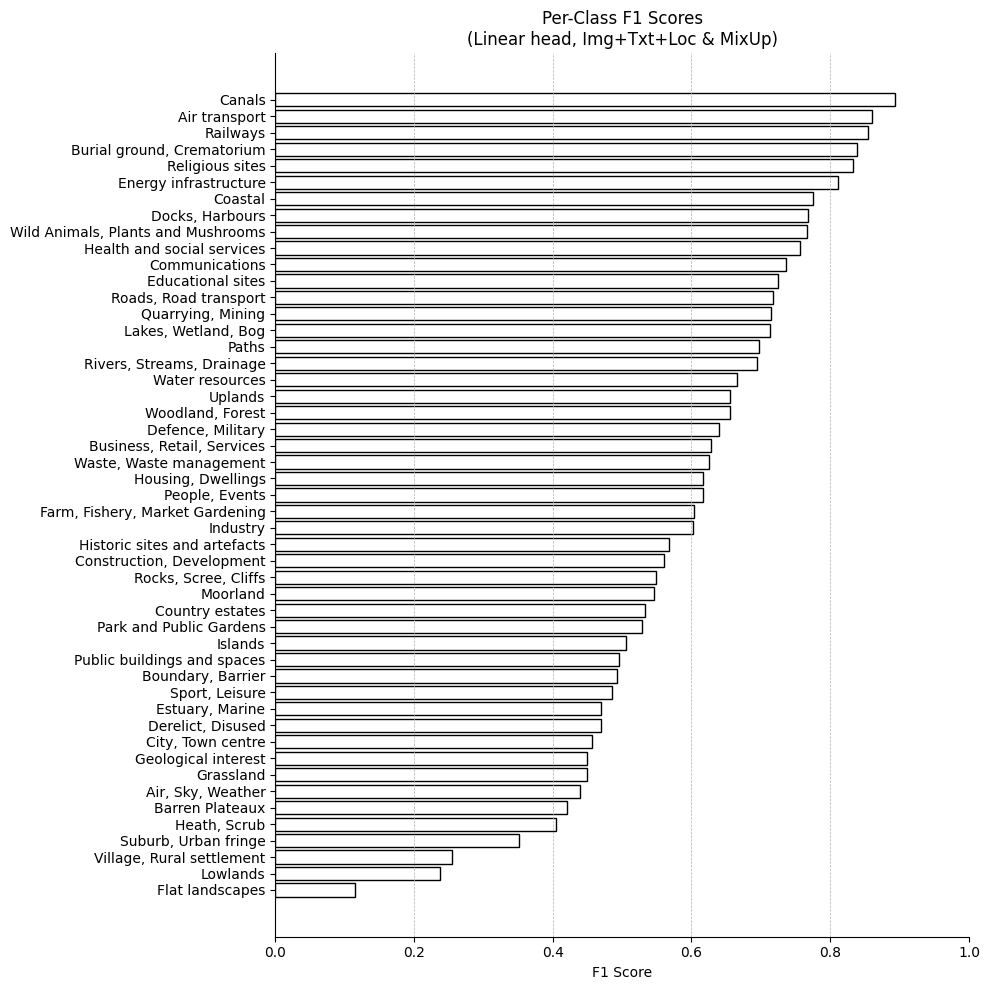

In [99]:
import matplotlib.pyplot as plt

# Sort by F1 score (ascending so high scores are at the top)
f1_df_sorted = f1_df.sort_values(by='f1_score', ascending=True)

plt.figure(figsize=(10, 10))

plt.barh(
    f1_df_sorted['tag'], 
    f1_df_sorted['f1_score'], 
    color='white',
    edgecolor='black'
)

plt.xlabel('F1 Score')
plt.title(f'Per-Class F1 Scores\n(Linear head, Img+Txt+Loc & MixUp)')
plt.xlim(0, 1)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save and show
plt.savefig(f'figures/f1_bar_{head_name.replace(".pth", "")}.pdf', dpi=300)
plt.show()

## Let's look at misclassified images

In [2]:
import random
from PIL import Image
from pathlib import Path

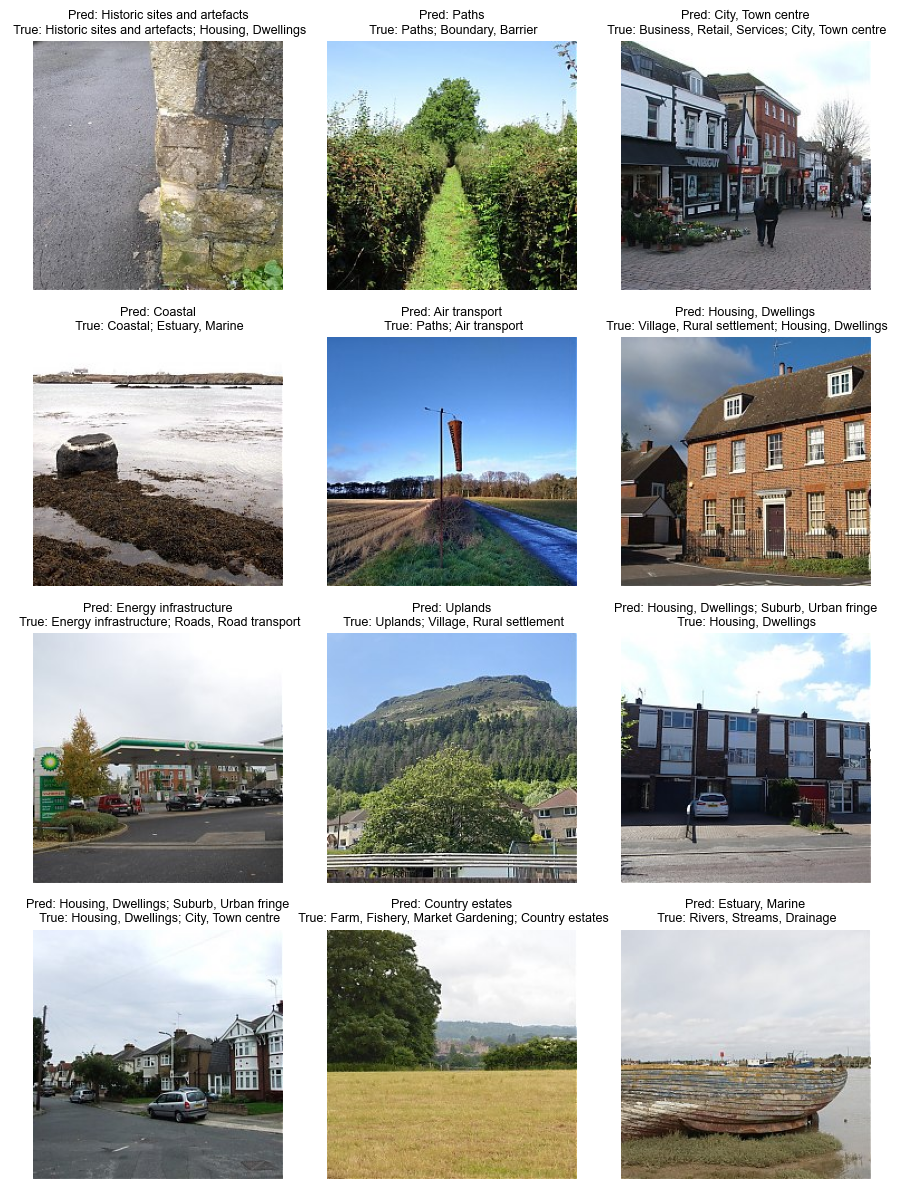

In [174]:
fig, axes = plt.subplots(4, 3, figsize=(9, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):

    while True:
        
        idx = int(random.random() * len(img_ids))
        img_id = img_ids[idx]
        path = Path('train_images') / f'{img_id//10000:05d}' / f'{img_id}.jpg'
    
        tags_predicted = [ tags_human[i] for i, v in enumerate(y_pred[idx]) if v == 1 ]
        tags_actual = [ tags_human[i] for i, v in enumerate(y_true[idx]) if v == 1 ]
    
        if tags_predicted == tags_actual or len(tags_predicted) > 2 or len(tags_actual) > 2 or len(tags_predicted) == 0:
            continue
    
        ax.imshow(Image.open(path))
        ax.axis('off')
    
        # Display as text under image
        ax.set_title(f"Pred: {'; '.join(tags_predicted)}\n True: {'; '.join(tags_actual)}", fontsize=9)

        break

plt.tight_layout()
plt.savefig("figures/misclassified.pdf", format="pdf")
plt.show()